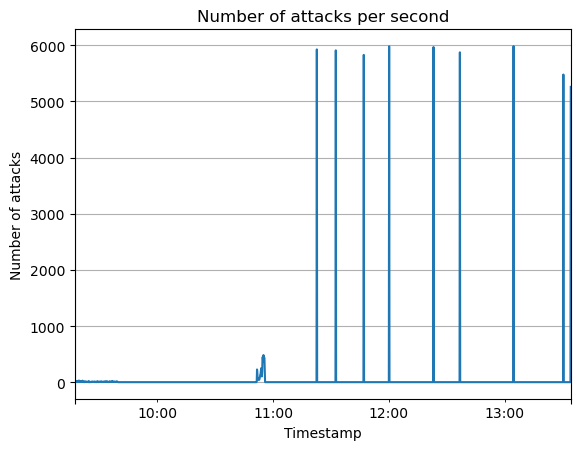

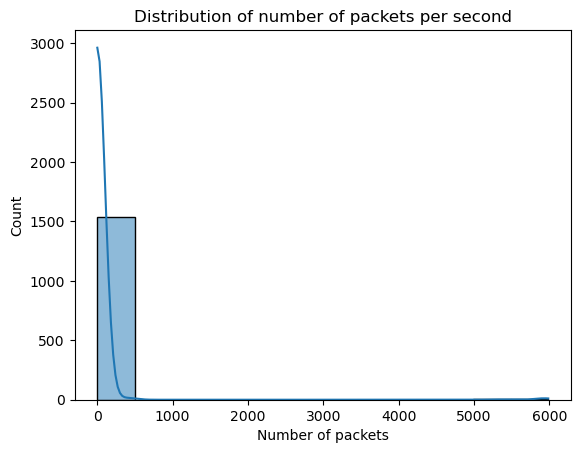

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ddos_data = pd.read_csv('ddos_dataset.csv', low_memory=False)

operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious].resample('10S').count()

df_result['Flow ID'].plot()
plt.xlabel('Timestamp')
plt.ylabel('Number of attacks')
plt.title('Number of attacks per second')
plt.grid()
plt.show()

plt.figure()
sns.histplot(data=df_result, x=' Source IP', kde=True)
plt.xlabel('Number of packets')
plt.title('Distribution of number of packets per second')
plt.show()



Let's analyze the top 5 destination IP reached by attacks

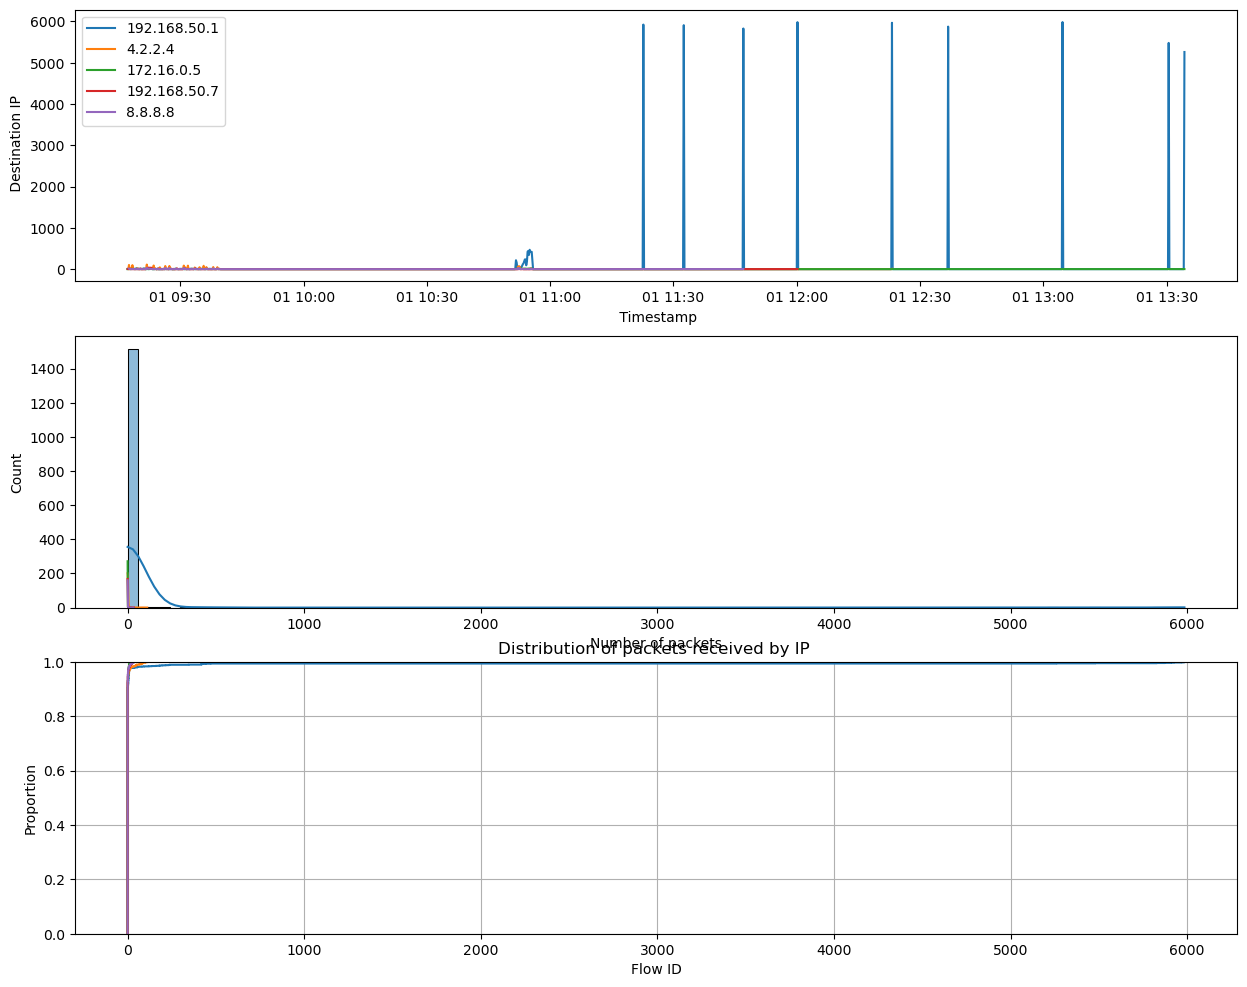

In [3]:
ip_top5 = operational_df.groupby(' Destination IP').count().sort_values(by='Flow ID', ascending=False).index[:5]

num_packets = []
t_df = operational_df.copy()
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
for ip in ip_top5:
    mask_ip = t_df[' Destination IP'] == ip
    temp_df = t_df[mask_ip].resample('10S').count()
    sns.lineplot(data=temp_df, y=' Destination IP', x=' Timestamp', label=ip, ax=ax[0])
    plt.title(f'Distribution of packets received by IP ')

    sns.histplot(data=temp_df, x=' Destination IP', kde=True, label=ip, ax=ax[1], bins=100)
    ax[1].set_xlabel('Number of packets')
    sns.ecdfplot(data=temp_df['Flow ID'])
    plt.grid()
plt.show()

Since the top IP destination has received a lot more packets in respect of the other, let's exclude it and analyze the other 4 for a clear representation of also the othre targeted IP

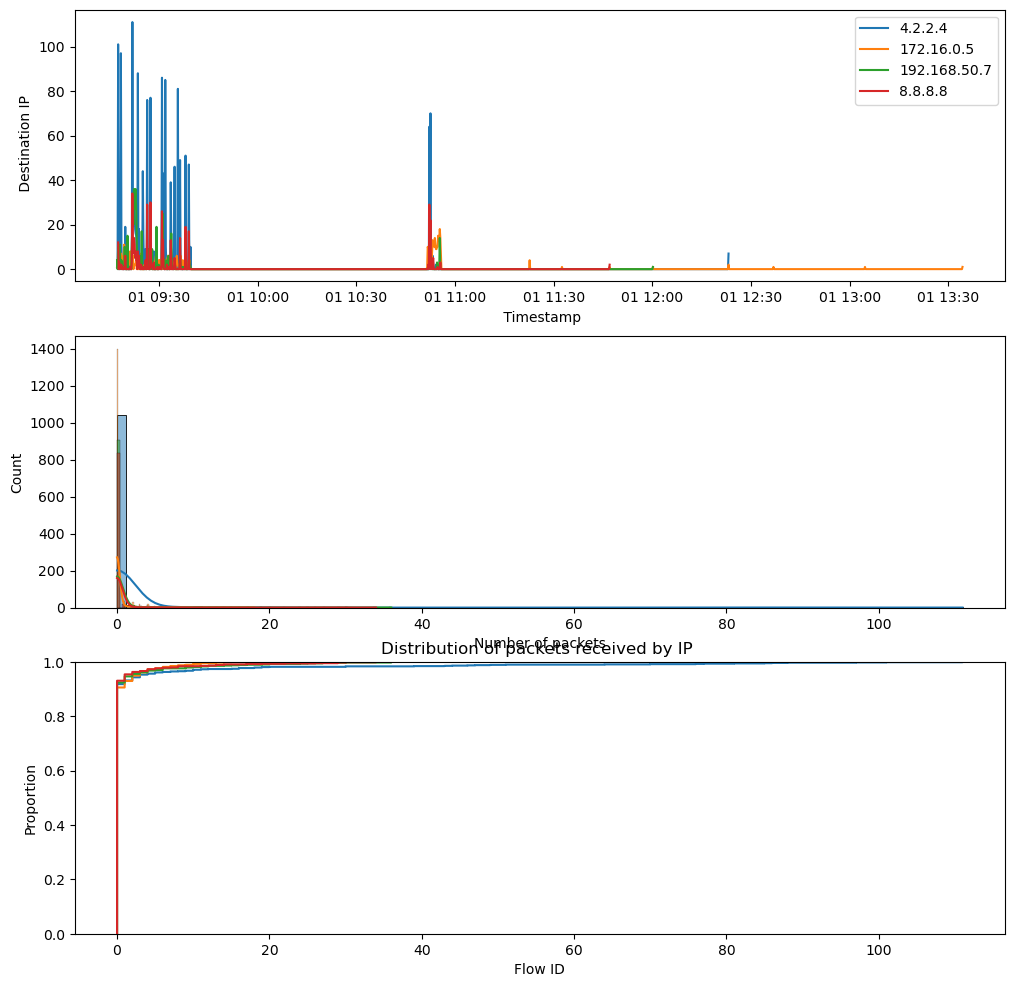

In [4]:
ip_top5 = operational_df.groupby(' Destination IP').count().sort_values(by='Flow ID', ascending=False).index[1:5]

num_packets = []
t_df = operational_df.copy()
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for ip in ip_top5:
    mask_ip = t_df[' Destination IP'] == ip
    temp_df = t_df[mask_ip].resample('10S').count()
    sns.lineplot(data=temp_df, y=' Destination IP', x=' Timestamp', label=ip, ax=ax[0])
    plt.title(f'Distribution of packets received by IP ')

    sns.histplot(data=temp_df, x=' Destination IP', kde=True, label=ip, ax=ax[1], bins=100)
    ax[1].set_xlabel('Number of packets')
    sns.ecdfplot(data=temp_df['Flow ID'])
    plt.grid()
plt.show()

 Protocol
0        18
6     11857
17    46706
Name: Flow ID, dtype: int64


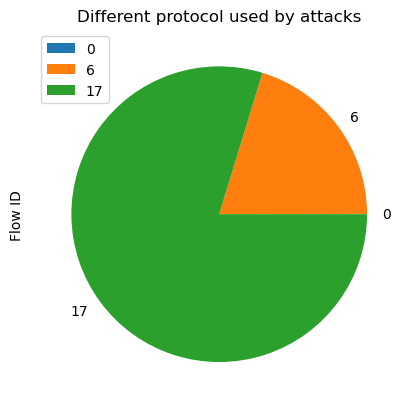

In [5]:
malicious_df = operational_df[mask_malicious].copy()
protocol_df = malicious_df.groupby(' Protocol').count()['Flow ID']
protocol_df.plot(kind='pie', title='Different protocol used by attacks')
plt.legend()
print(protocol_df)

Even if the protol 0 seems to be not used, it is indeed. This visualization is due to the fact that the count for each protocol is:
0        18
6     11857
17    46706

<AxesSubplot: xlabel='label'>

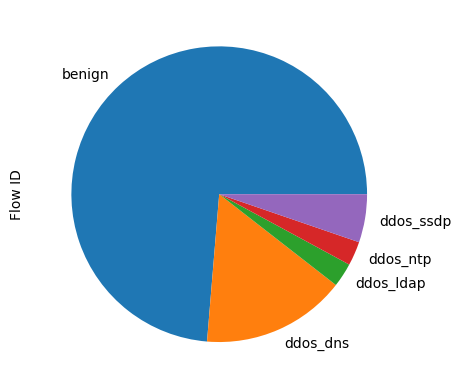

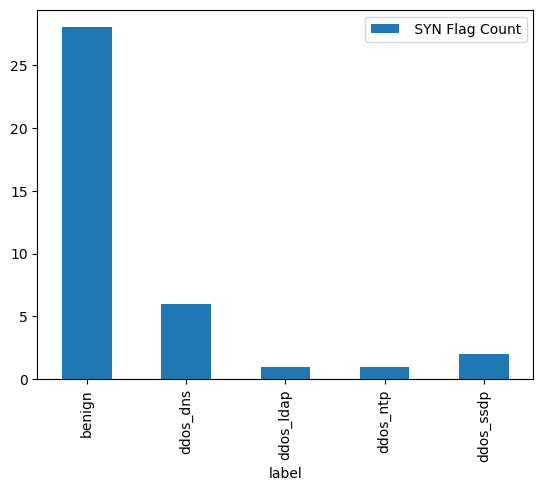

In [6]:
mask_SYN = operational_df[' SYN Flag Count'] != 0
SYN_df = operational_df[mask_SYN].groupby('label').count()['Flow ID']
SYN_df.plot(kind='pie')
at_SYN_df = operational_df[mask_SYN]
at_SYN_df[[' SYN Flag Count', 'label']].groupby('label').count().plot(kind='bar')

Now it's time to analyze the kind of attack or data flow characterized by the SYN flag high in the TCP protocol

<AxesSubplot: ylabel='Flow ID'>

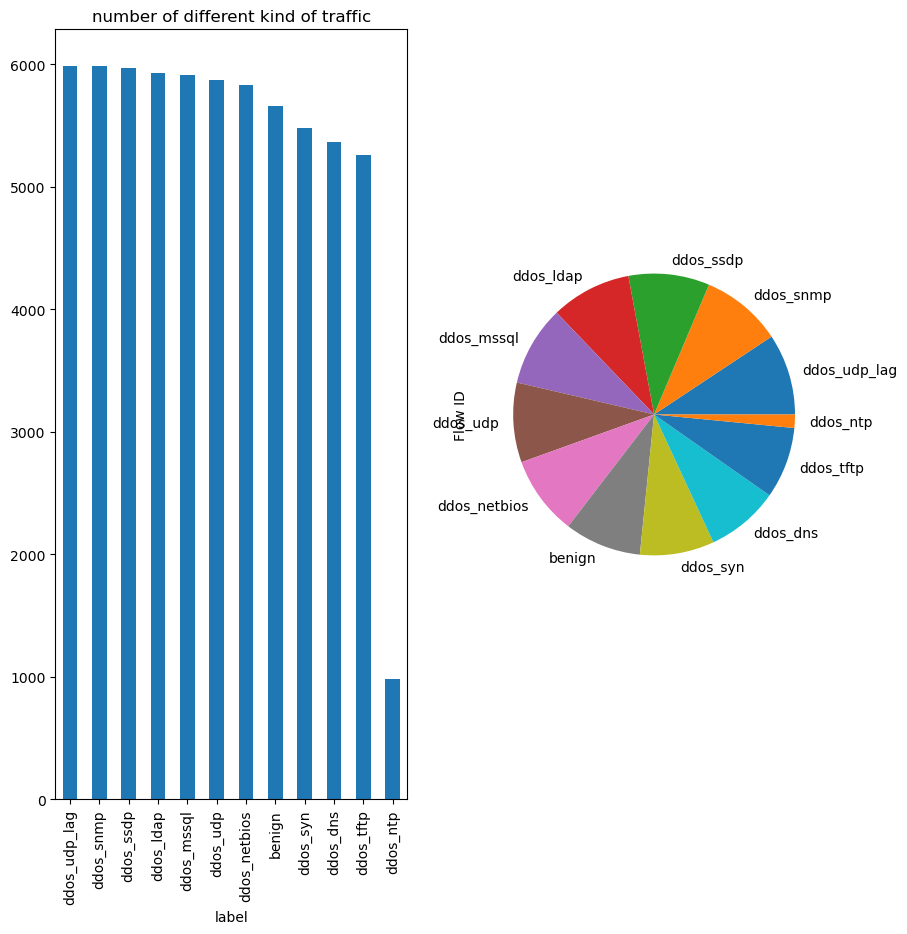

In [7]:
df_attacks = operational_df.groupby('label').count().sort_values(by='Flow ID', ascending=False)
attacks = df_attacks.index
fig, ax = plt.subplots(1,2)
df_attacks['Flow ID'].plot(kind='bar', title='number of different kind of traffic', ax=ax[0], figsize=(10,2))
df_attacks['Flow ID'].plot(kind='pie', ax=ax[1], figsize=(10,10))

<AxesSubplot: title={'center': 'Top 10 Flow ID number of packets'}, xlabel='Flow ID'>

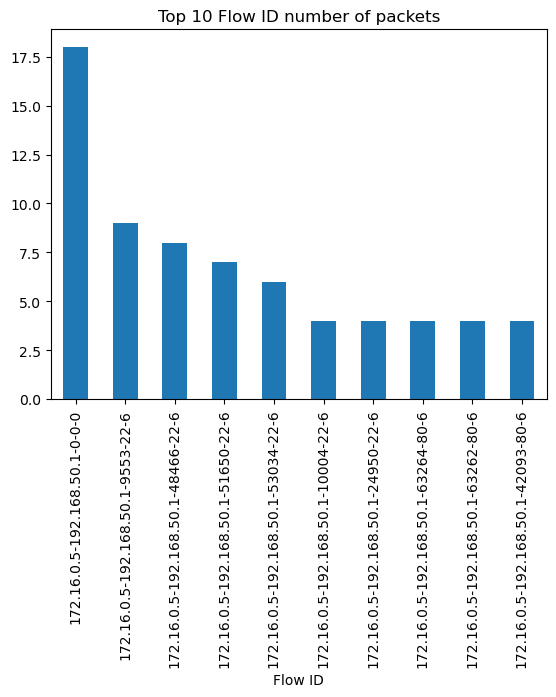

In [8]:
mask_bening = operational_df['label'] != 'benign'
df_flow_id = operational_df[mask_bening].groupby('Flow ID').count().sort_values(by=' Source IP', ascending=False)[:10]
df_flow_id[' Source IP'].plot(kind='bar', title='Top 10 Flow ID number of packets')

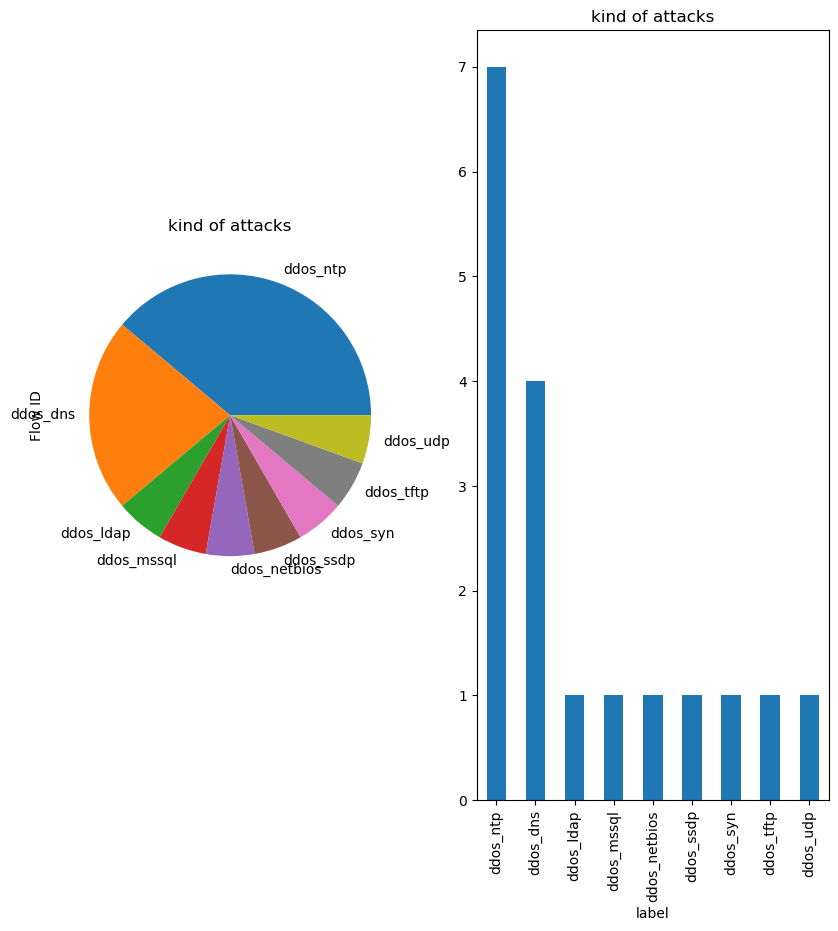

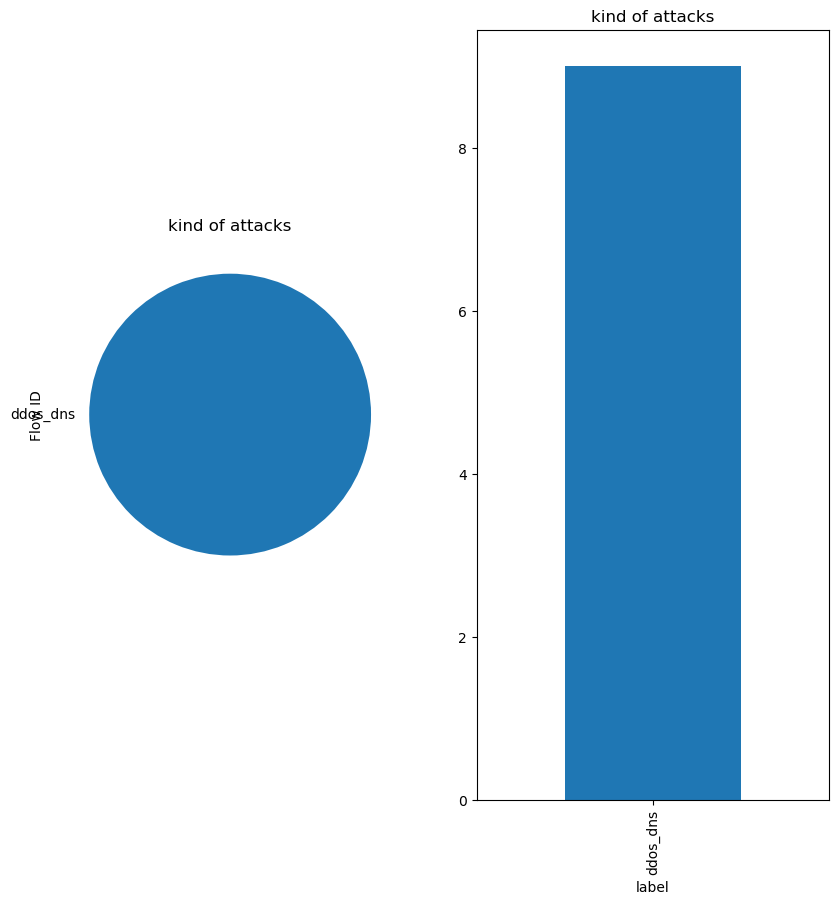

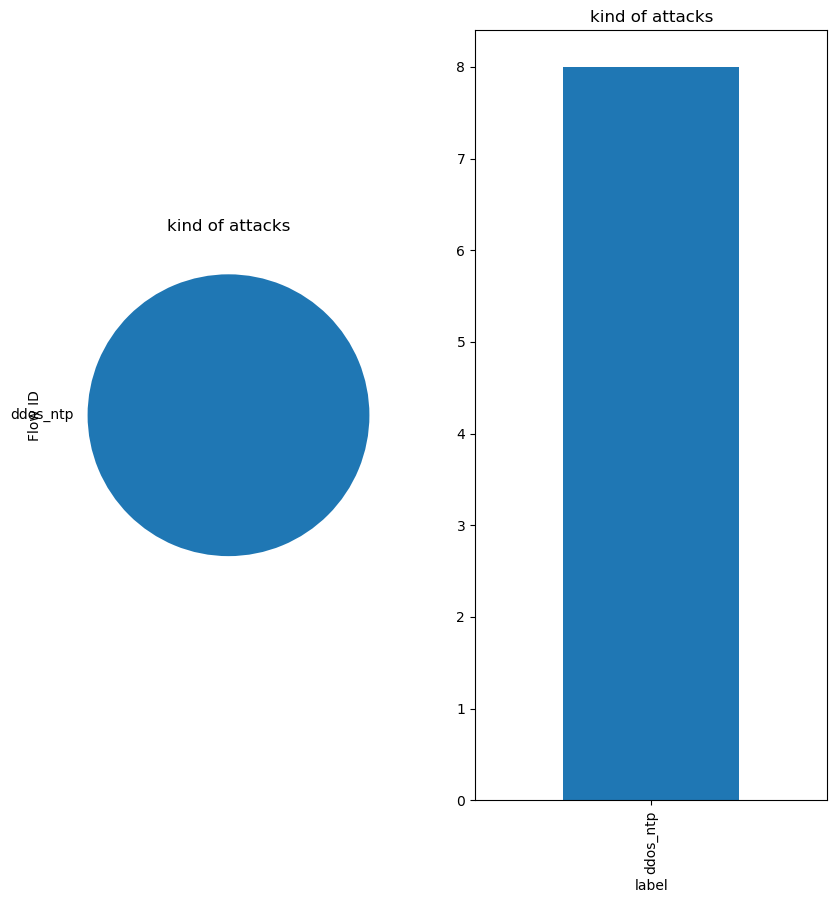

In [9]:
for i, index in enumerate(df_flow_id.index[:3]):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    mask_index = operational_df['Flow ID'] == index
    df_plot = operational_df[mask_index].groupby('label').count().sort_values(by='Flow ID', ascending=False)['Flow ID']
    df_plot.plot(kind='pie', title= 'kind of attacks', ax=ax[0])
    df_plot.plot(kind='bar', title= 'kind of attacks', ax=ax[1])



Analysis of the top 10 common link (Flow ID, Source Port, Destination Port) and the relative attack (the benign flow has been removed) based on the number of packets exchanged

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


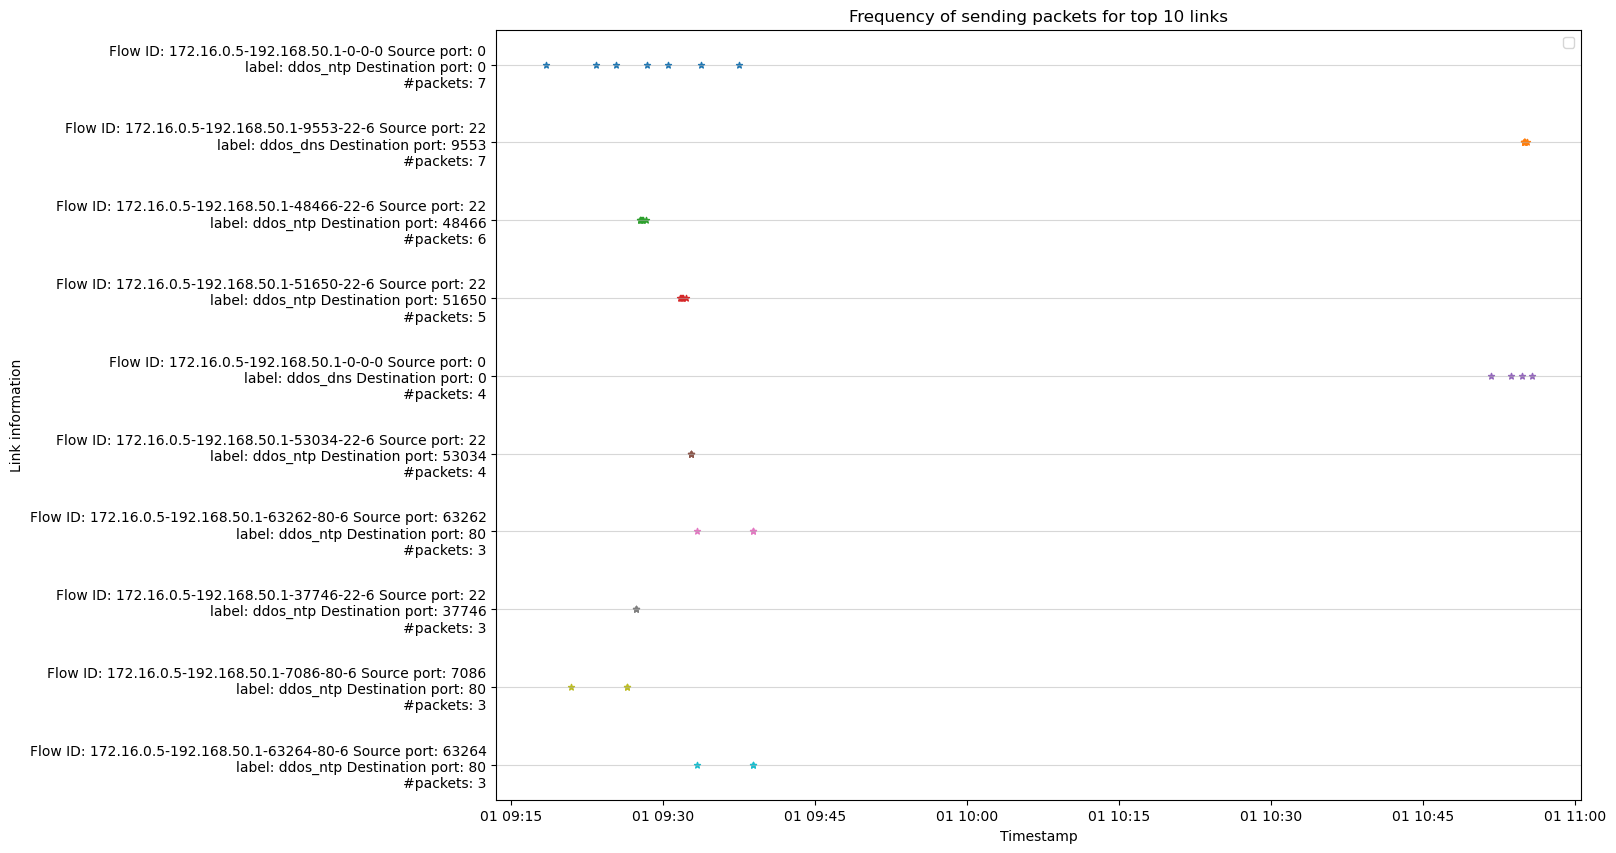

In [10]:
top_10_link = operational_df[operational_df['label'] != 'benign'].groupby(['Flow ID', 'label', ' Source Port', ' Destination Port']).count().sort_values(by=' Source IP', ascending=False).index[:10]
plt.figure(figsize=(14, 10))
ytick_labels = []
for n, link in enumerate(top_10_link):
    flow_id = link[0]
    flow_type = link[1]
    src_port = link[2]
    dst_port = link[3]
    df_link = operational_df[
        (operational_df['Flow ID'] == flow_id) &
        (operational_df[' Source Port'] == src_port) &
        (operational_df['label'] == flow_type) &
        (operational_df[ ' Destination Port'] == dst_port)
    ]
    plt.scatter(
        df_link.index,
        [10-n for _ in range(len(df_link))],
        s = 20, 
        marker = '*'
    )
    # create the label of each link for y-axis
    ytick_label = f'Flow ID: {flow_id} ' + \
                  f'Source port: {src_port}\n' + \
                  f'label: {flow_type} ' + \
                  f'Destination port: {dst_port}\n' + \
                  f'#packets: {len(df_link)}'
    ytick_labels.append(ytick_label)
plt.xlabel('Timestamp') 
plt.ylabel('Link information')
# the first list the the location of the label
# the second list is the label you want to assign to each location
plt.yticks([x for x in range(10,0,-1)], ytick_labels) 
plt.title('Frequency of sending packets for top 10 links')
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

PCA 

/tmp/ipykernel_16846/3997408796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = operational_df.drop(columns='label').corr().abs().round(2)


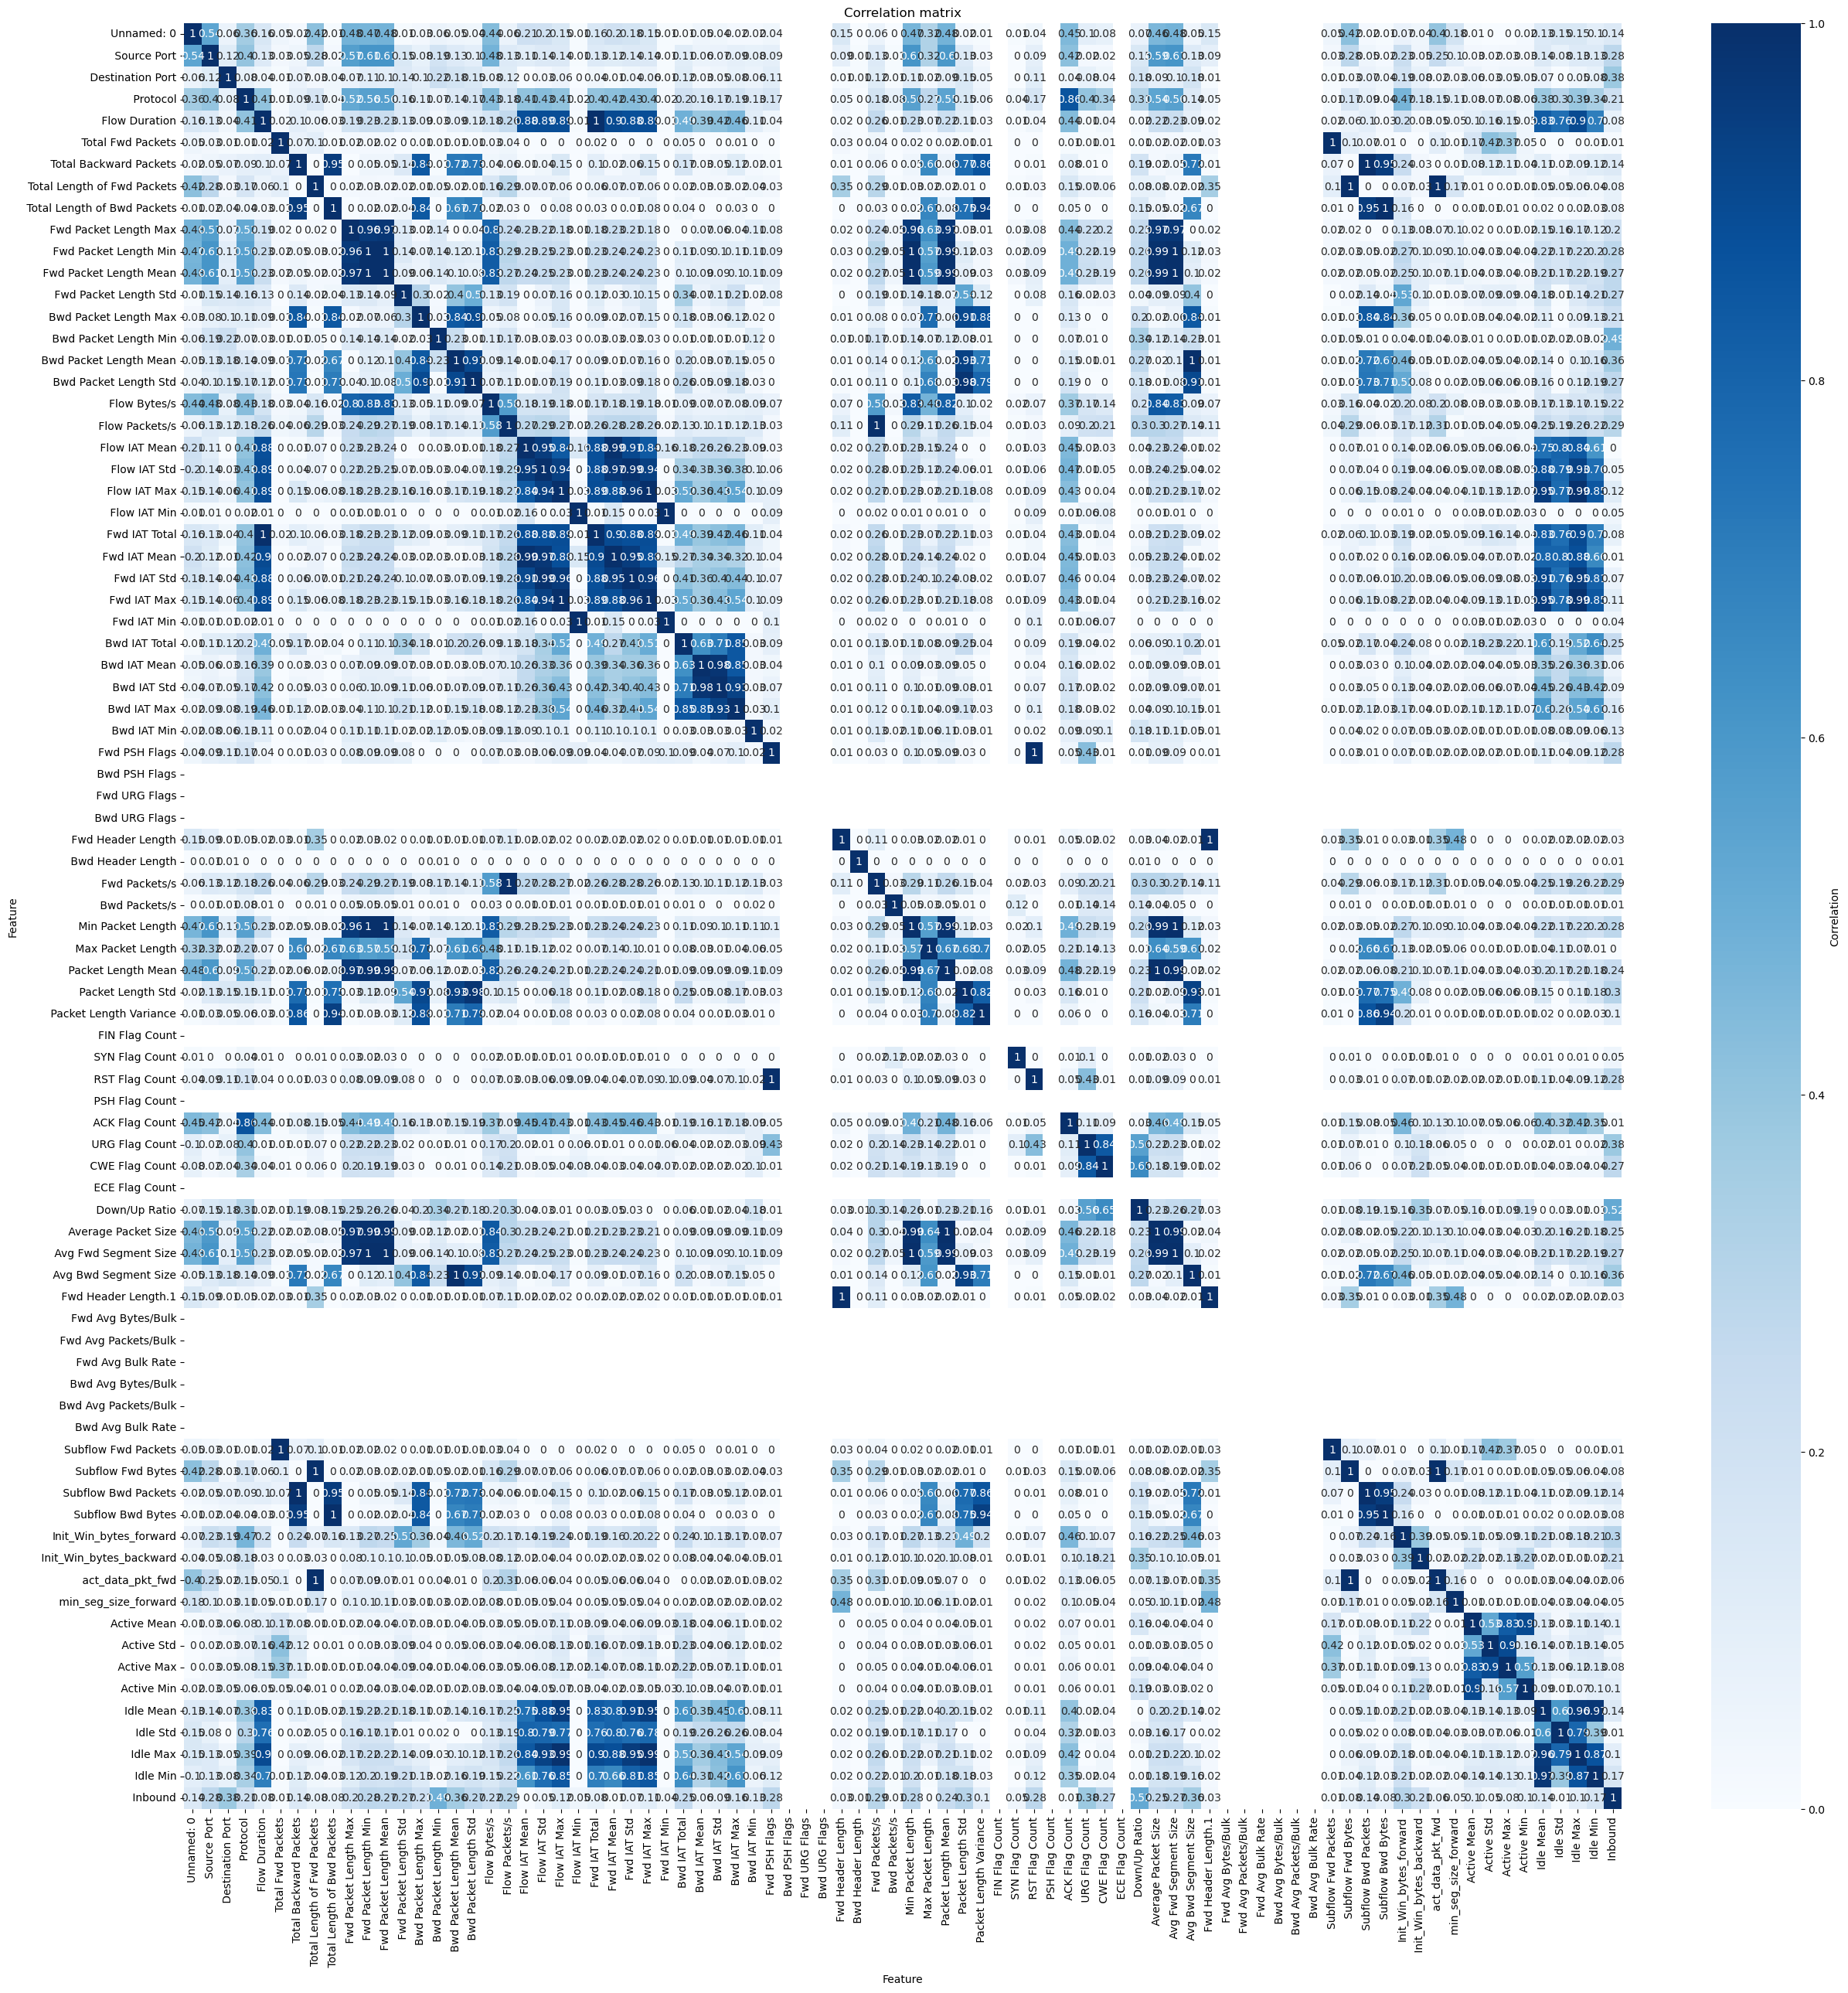

In [14]:
correlation_matrix = operational_df.drop(columns='label').corr().abs().round(2)
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

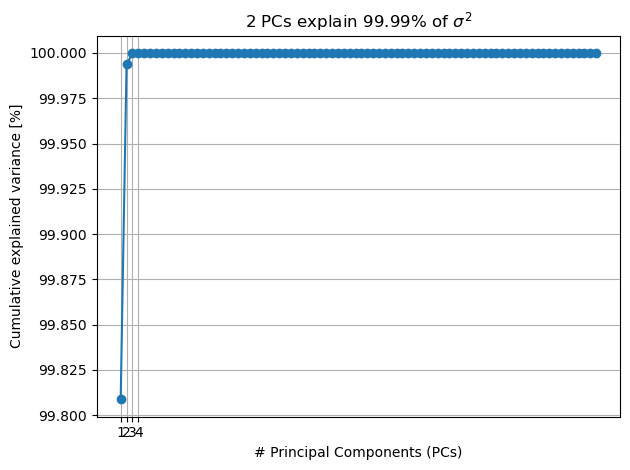

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(random_state=15)
pca.fit(operational_df.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100

plt.figure()
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(4)], [i for i in range (1,5)])
plt.grid()
plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

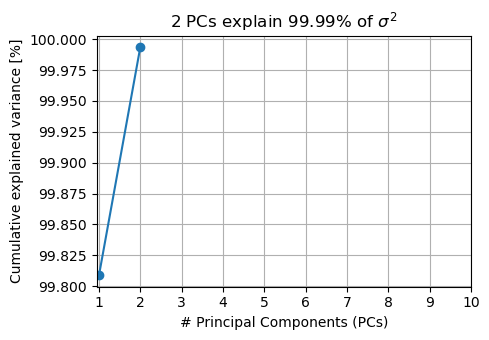

In [30]:
pca = PCA(n_components=2, random_state=15)
pca.fit(operational_df.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))
pca_result = pca.transform(operational_df.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

pca_df = pd.DataFrame(pca_result, columns=['c1', 'c2'])
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(10)], [i for i in range(1,11)])
plt.grid()
plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

                             PC1           PC2
Unnamed: 0          -2810.691970 -8.582557e+03
 Source Port        -2343.794179 -1.211819e+04
 Destination Port     266.035071  1.752868e+03
 Protocol               0.257488  2.043245e+00
 Flow Duration    -486967.262735 -3.999827e+06
...                          ...           ...
Idle Mean         -104385.084275 -8.969337e+05
 Idle Std          -25518.875945 -2.030367e+05
 Idle Max         -143418.223255 -1.207495e+06
 Idle Min          -78539.903728 -6.913026e+05
 Inbound                0.007820  6.044252e-02

[82 rows x 2 columns]


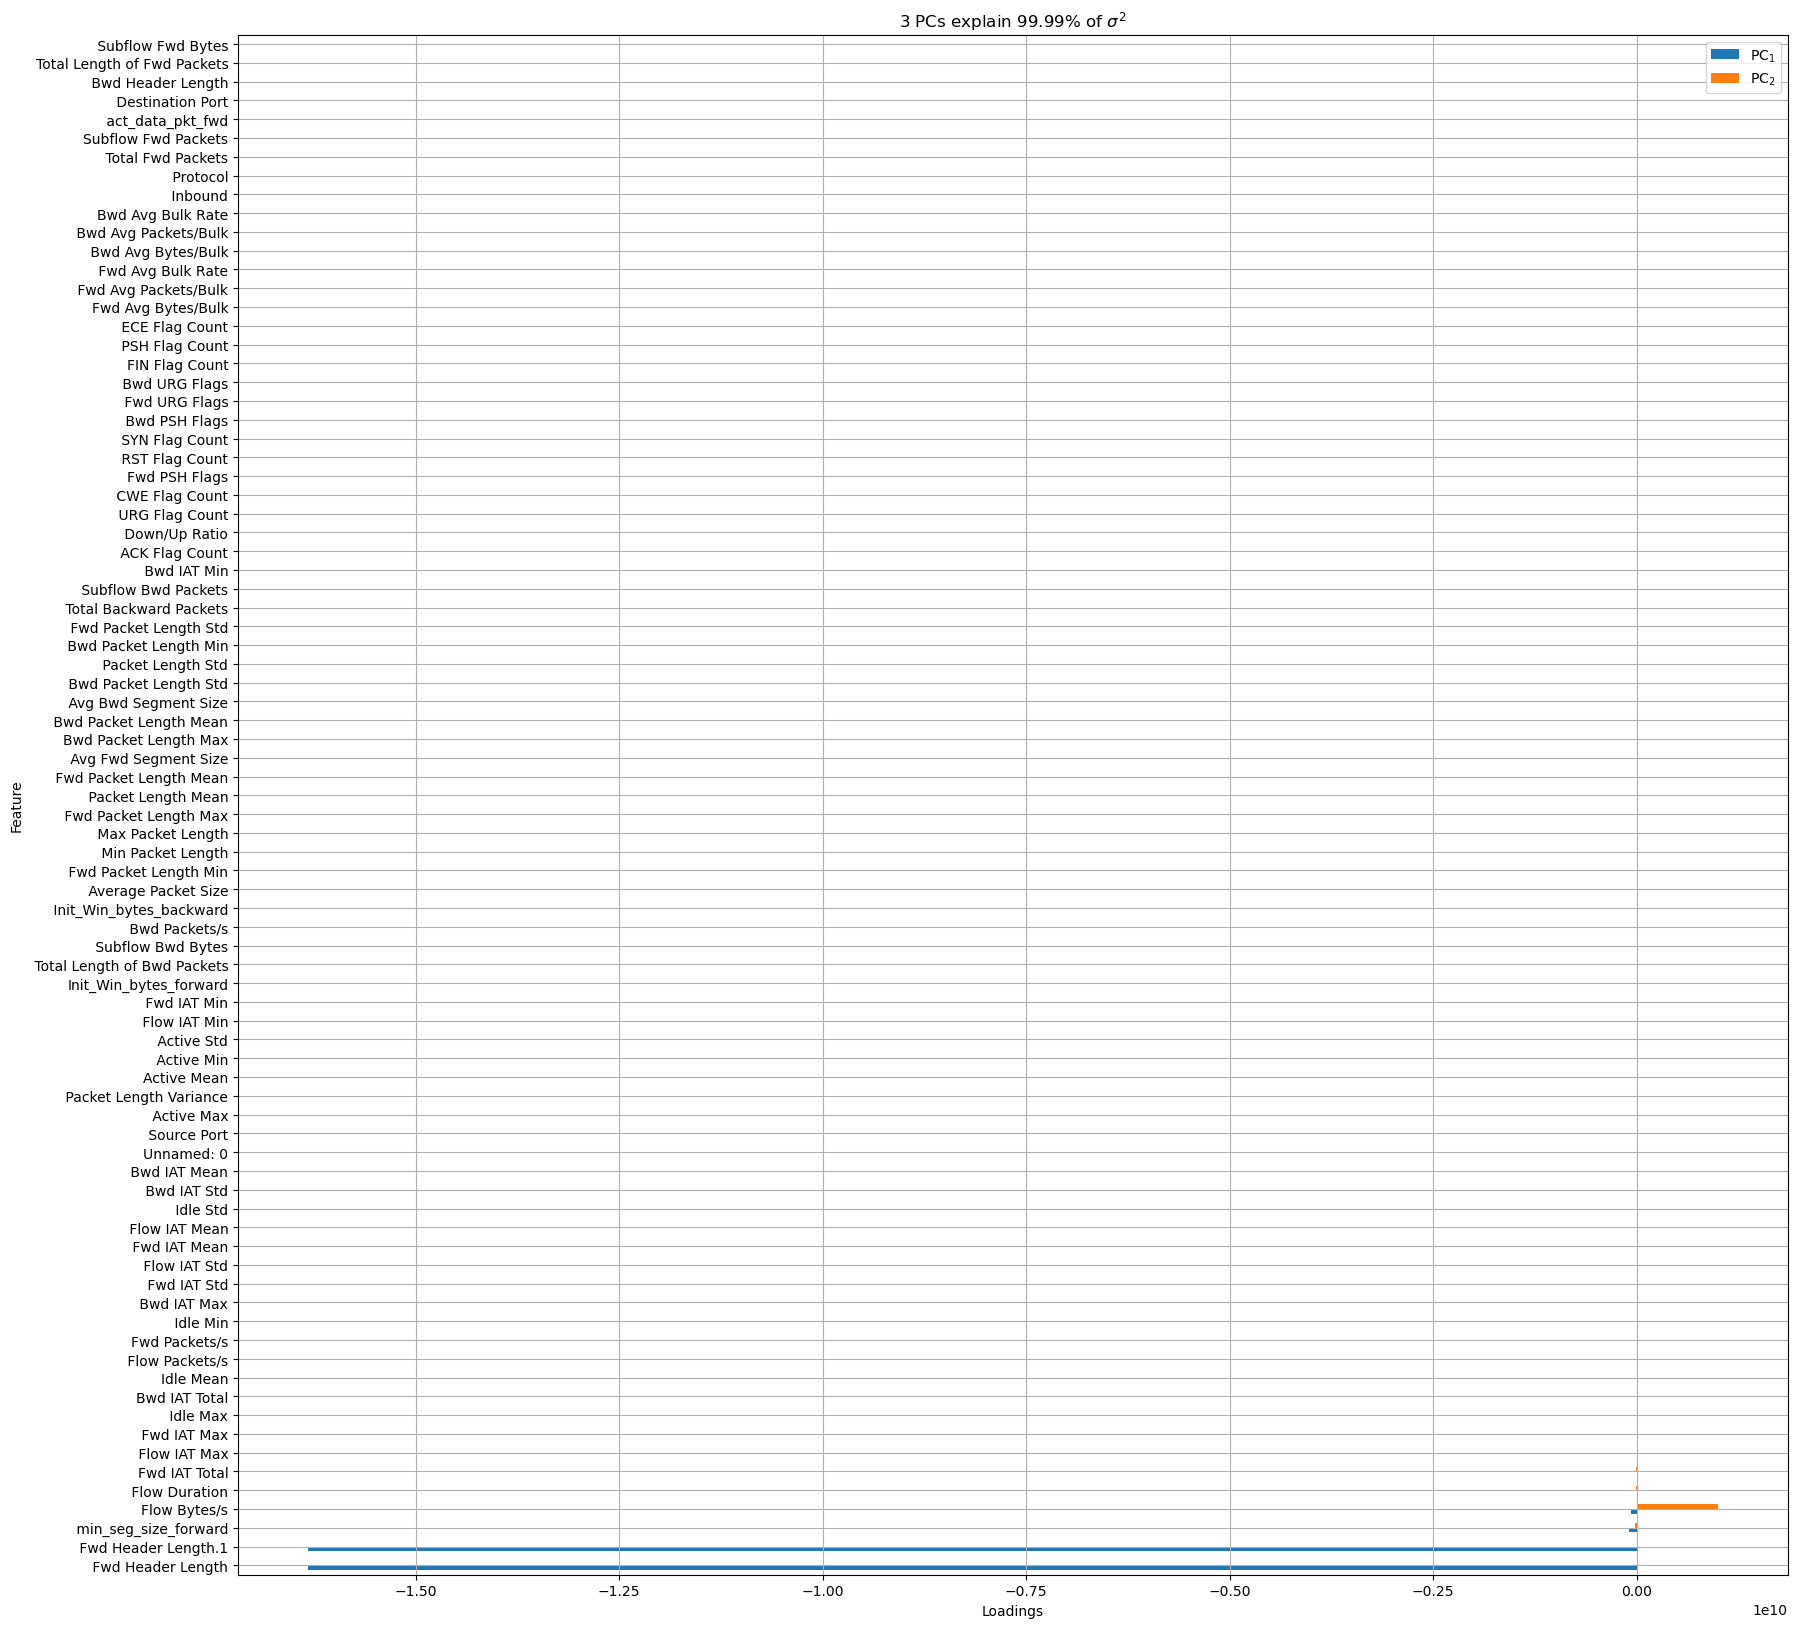

In [35]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 3)],
    index = operational_df.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']).columns
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2']]
print(loadings)
loadings.sort_values(['PC1', 'PC2']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'3 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')
plt.show()